In [1]:
# A/B Testing


Took a sample dataset from Kaggle to run A/B testing with conversion rates.

In [16]:
## Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

In [17]:
df = pd.read_csv("C:/Users/kashi/Downloads/AB_Test_Results.csv")
print(df.head())
df['revenue_true'] = np.where(df['REVENUE'] > 0 , 1, 0)
print(df.head())

   USER_ID VARIANT_NAME  REVENUE
0      737      variant      0.0
1     2423      control      0.0
2     9411      control      0.0
3     7311      control      0.0
4     6174      variant      0.0
   USER_ID VARIANT_NAME  REVENUE  revenue_true
0      737      variant      0.0             0
1     2423      control      0.0             0
2     9411      control      0.0             0
3     7311      control      0.0             0
4     6174      variant      0.0             0


In [18]:
effect_size = sms.proportion_effectsize(0.01, 0.03)

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )        
# Calculating sample size needed
required_n = ceil(required_n) 
print(required_n)
# We need 719 observations from control and variant

719


In [19]:
df.info()
control = df[df['VARIANT_NAME'] == 'control'].sample(n=required_n)
variant = df[df['VARIANT_NAME'] == 'variant'].sample(n=required_n)

ab_test = pd.concat([control, variant], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

ab_test['VARIANT_NAME'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
 3   revenue_true  10000 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 273.6+ KB


variant    719
control    719
Name: VARIANT_NAME, dtype: int64

In [20]:
conversion_rates = ab_test.groupby('VARIANT_NAME')['revenue_true']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
VARIANT_NAME,,,
control,0.015,0.123,0.005
variant,0.010,0.098,0.004


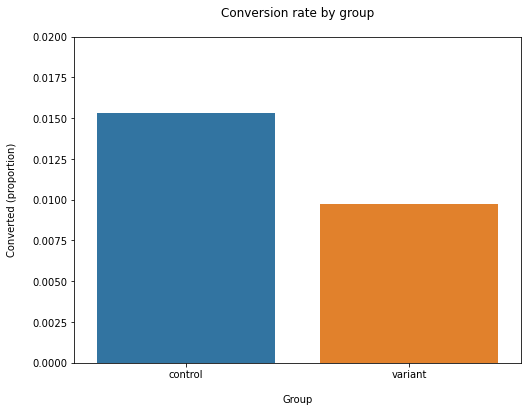

In [22]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['VARIANT_NAME'], y=ab_test['revenue_true'], ci=False)

plt.ylim(0, 0.02)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [14]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['VARIANT_NAME'] == 'control']['revenue_true']
variant_results = ab_test[ab_test['VARIANT_NAME'] == 'variant']['revenue_true']
n_con = control_results.count()
n_treat = variant_results.count()
successes = [control_results.sum(), variant_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for variant group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.98
p-value: 0.048
ci 95% for control group: [0.010, 0.031]
ci 95% for variant group: [0.002, 0.015]
